In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(
    '/content/drive/MyDrive/dataset/train.csv',
    delimiter=',',
)


**Обработка отсутствующих значений**

In [ ]:
import matplotlib.pyplot as plt

dict = {}

for i in list(data):
  dict[i] = data[i].isna().sum()

categories = []
values = []

for i in dict:
    if dict[i] > 0:
        categories.append(i)
        values.append(int(dict[i] / len(data) * 100))

print(categories)
plt.figure(figsize=(15, 6))
plt.bar(categories, values)
plt.xticks(rotation=90)
plt.xlabel('Поля')
plt.ylabel('% NaN от общего числа строк')
plt.axhline(y=100)

In [ ]:
cafe = ['cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg', 'cafe_avg_price_500', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_avg_price_3000']
for i in cafe:
  mean_value = data[i].mean()
  data[i].fillna(int(mean_value), inplace=True)



In [ ]:
mean_coefficient = (data['life_sq'] / data['full_sq']).median()
def fill_missing_life_sq(row):
    if pd.isnull(row['life_sq']):
        return int(row['full_sq'] * mean_coefficient)
    else:
        return row['life_sq']

data['life_sq'] = data.apply(fill_missing_life_sq, axis=1)

In [ ]:
def floor(row):
    if pd.isnull(row['max_floor']):
        return row['floor']
    else:
        return row['max_floor']
data['max_floor'] = data.apply(floor, axis=1)

In [ ]:
data["material"].fillna(int(data["material"].median()), inplace=True)

In [ ]:
mean_value = data["build_year"].median()
data["build_year"].fillna(mean_value, inplace=True)


In [ ]:
def room(row):
    if pd.isnull(row['num_room']):
        return max(1, row['life_sq'] // 20) #20 квадратных метров- средний размер комнаты
    else:
        return row['num_room']

data['num_room'] = data.apply(room, axis=1)

In [ ]:
mean_value = data["kitch_sq"].median()
data["kitch_sq"].fillna(int(mean_value), inplace=True)

In [ ]:
mean_value = data["state"].median()
data["state"].fillna(int(mean_value), inplace=True)

In [ ]:
mean_value = data['preschool_quota'].median()
data['preschool_quota'].fillna(int(mean_value), inplace=True)

In [ ]:
mean_value = data['school_quota'].median()
data['school_quota'].fillna(int(mean_value), inplace=True)

In [ ]:
macro = pd.read_csv(
    '/content/drive/MyDrive/dataset/macro.csv',
    delimiter=',',
)

def hospital(row):
    if pd.isna(row['hospital_beds_raion']):
        return row['raion_popul'] / 100000 * macro[macro['timestamp'] == row["timestamp"]].iloc[0]['hospital_beds_available_per_cap']
    else:
        return row['hospital_beds_raion']

data['hospital_beds_raion'] = data.apply(hospital, axis=1)


In [ ]:
data = data.dropna(axis=0)
print(len(data))

24351


**Обработка лишних значений**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = data.copy()
df = df.dropna(axis=0)
print(len(df))
corr_matrix = df.corr()

24351


<ipython-input-34-5567a48fbb1d>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


In [ ]:
from pprint import pprint
spisok = []

for i in list(corr_matrix):
  for j in list(corr_matrix):
    if i != j:
      if (j, i, corr_matrix[i][j]) not in spisok:
        spisok.append((i, j, corr_matrix[i][j]))

spisok = sorted(spisok, key=lambda x: abs(x[2]), reverse=True)
spisok

In [ ]:
import random

st = set()
for i in spisok:
  if i[2] >= 0.96:
    st.add(i[random.randint(0, 1)])
print("Список столбцов, подлежащих удалению:", st)

Список столбцов, подлежащих удалению: {'cafe_avg_price_5000', 'cafe_sum_500_max_price_avg', '0_6_female', '16_29_male', 'cafe_count_2000_price_2500', '0_13_female', 'cafe_count_1000_price_2500', 'cafe_count_1000', 'office_count_1000', 'cafe_count_2000_price_4000', 'cafe_count_5000_price_1500', 'big_church_count_3000', 'cafe_count_3000_price_high', 'public_transport_station_km', 'ekder_male', 'school_km', 'church_count_1000', 'cafe_count_500_price_500', 'cafe_count_2000_price_1000', 'cafe_count_1500_price_2500', '0_6_male', 'cafe_sum_5000_min_price_avg', 'big_church_count_1500', 'cafe_avg_price_500', 'cafe_count_3000_price_500', 'cafe_avg_price_1000', 'church_count_2000', 'raion_build_count_with_builddate_info', 'cafe_count_5000_price_500', 'cafe_sum_2000_min_price_avg', 'female_f', '7_14_female', 'office_count_3000', 'cafe_count_500', 'cafe_count_5000', 'sadovoe_km', 'office_count_2000', '0_17_female', 'cafe_avg_price_1500', 'cafe_count_1500_price_1000', 'cafe_sum_1500_max_price_avg', 

**Выявление и удаление аномалий**

In [ ]:
new = data.copy()
q = 0.001
for i in list(data):
  if not new[i].apply(lambda x: isinstance(x, str)).any() and i != 'id':
    q_low = new[i].quantile(q)
    q_hi  = new[i].quantile(1 - q)
    new = new[(new[i] <= q_hi) & (new[i] >= q_low)]
    print(q_low, q_hi, i, len(new), q)



12.0 210.65000000000146 full_sq 24304 0.001
0.3030000000000008 165.0 life_sq 24259 0.001
1.0 31.0 floor 24233 0.001
0.0 40.0 max_floor 24221 0.001
1.0 6.0 material 24221 0.001
0.0 2017.0 build_year 24218 0.001
1.0 7.0 num_room 24198 0.001
0.0 42.0 kitch_sq 24174 0.001
1.0 4.0 state 24174 0.001
2104404.816 52351766.54 area_m 24138 0.001
19940.0 247469.0 raion_popul 24130 0.001
0.001879375 0.852922841 green_zone_part 24130 0.001
0.0 0.521867054 indust_part 24130 0.001
1491.0 19223.0 children_preschool 24130 0.001
0.0 11926.0 preschool_quota 24130 0.001
0.0 13.0 preschool_education_centers_raion 24130 0.001
1318.0 19083.0 children_school 24130 0.001
2012.0 24750.0 school_quota 24130 0.001
0.0 14.0 school_education_centers_raion 24130 0.001
0.0 2.0 school_education_centers_top_20_raion 24130 0.001
30.0 4849.0 hospital_beds_raion 24130 0.001
0.0 6.0 healthcare_centers_raion 24130 0.001
0.0 3.0 university_top_20_raion 24130 0.001
0.0 29.0 sport_objects_raion 24130 0.001
0.0 16.0 additional_e

In [ ]:
q = 0.015
i = "build_year"
q_low = new[i].quantile(q)
q_hi  = new[i].quantile(1 - q)
new = new[(new[i] <= q_hi) & (new[i] >= q_low)]
print(q_low, q_hi, i, len(new), q)

1.0 2015.0 build_year 20476 0.015


In [ ]:
q = 0.006
i = "life_sq"
q_low = new[i].quantile(q)
q_hi  = new[i].quantile(1 - q)
new = new[(new[i] <= q_hi) & (new[i] >= q_low)]
print(q_low, q_hi, i, len(new), q)

1.0 96.0 life_sq 20355 0.006


**Сбалансированность данных**



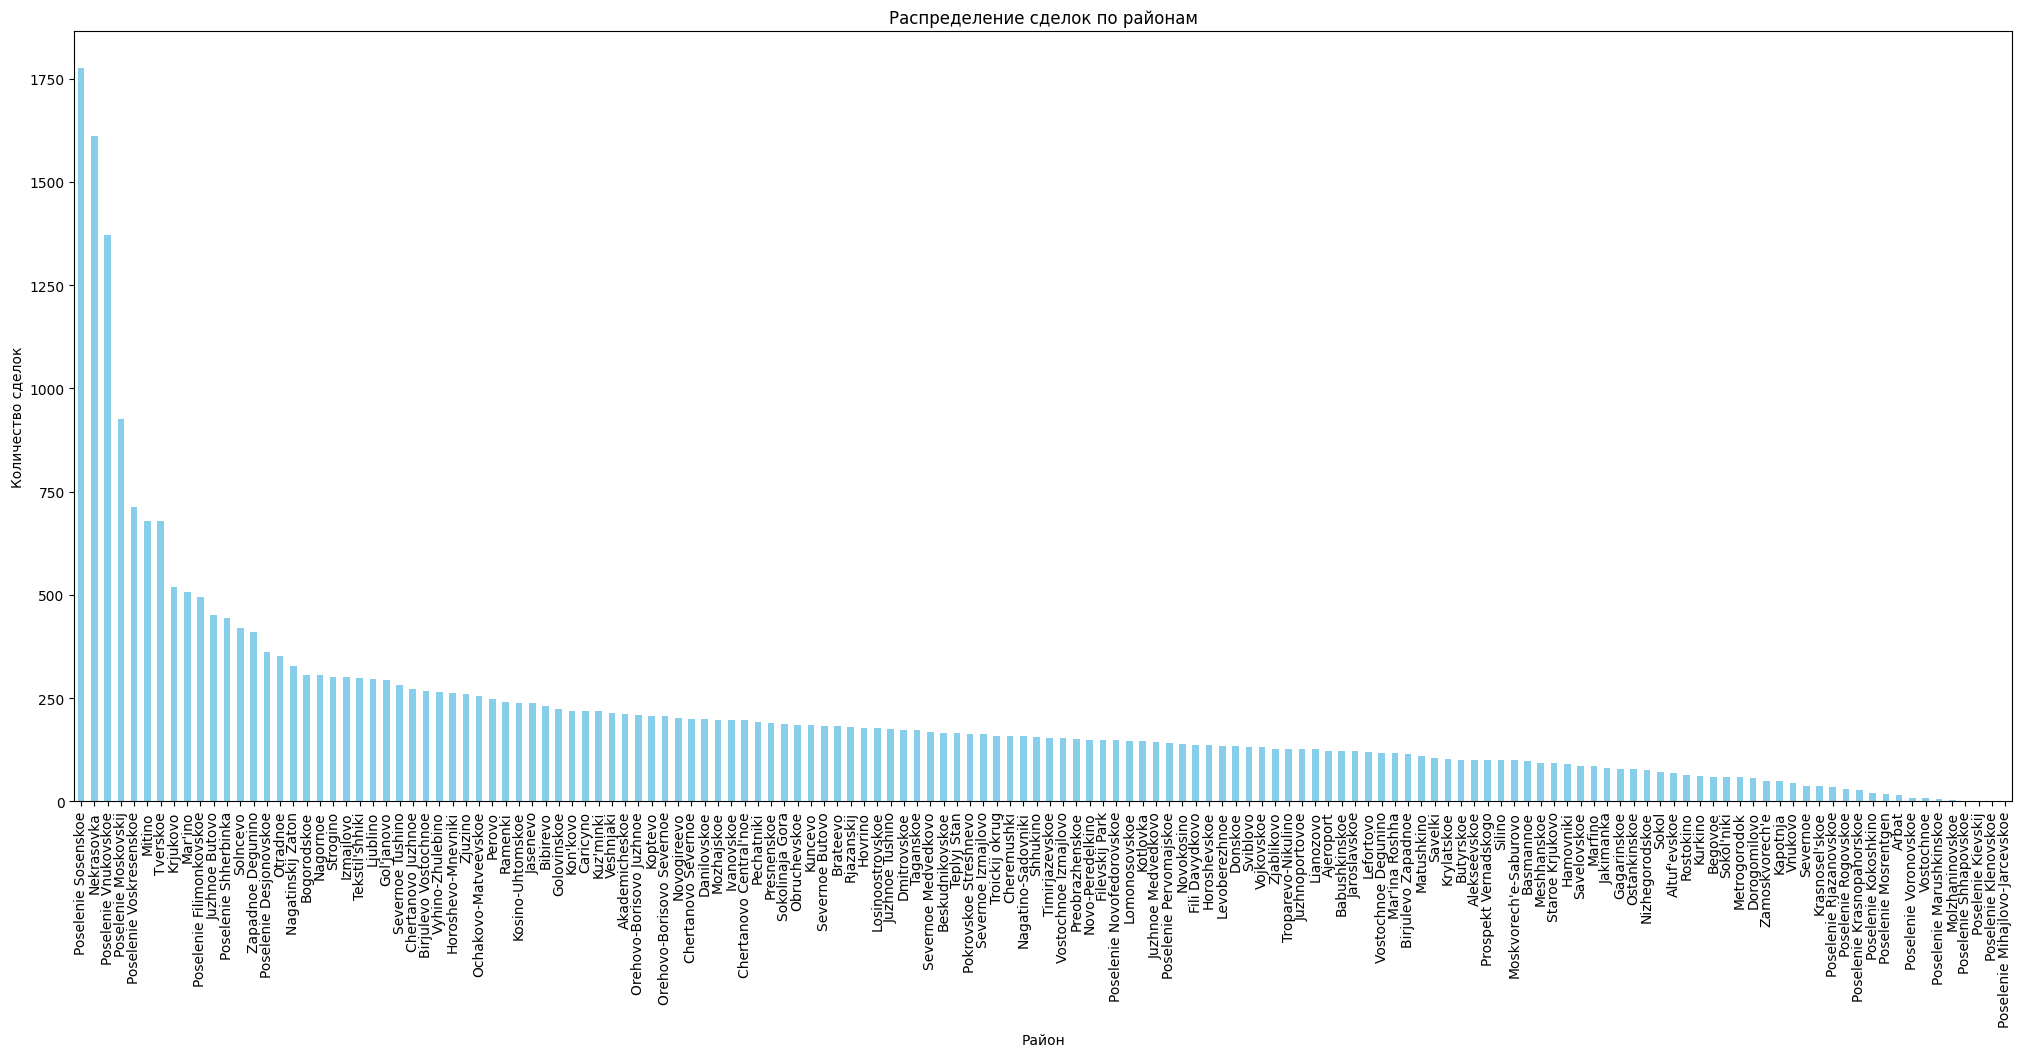

In [ ]:
data = pd.read_csv(
    '/content/drive/MyDrive/dataset/train.csv',
    delimiter=',',
)


plt.figure(figsize=(25, 10))
data['sub_area'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Район')
plt.ylabel('Количество сделок')
plt.title('Распределение сделок по районам')
plt.xticks(rotation=90)
plt.show()

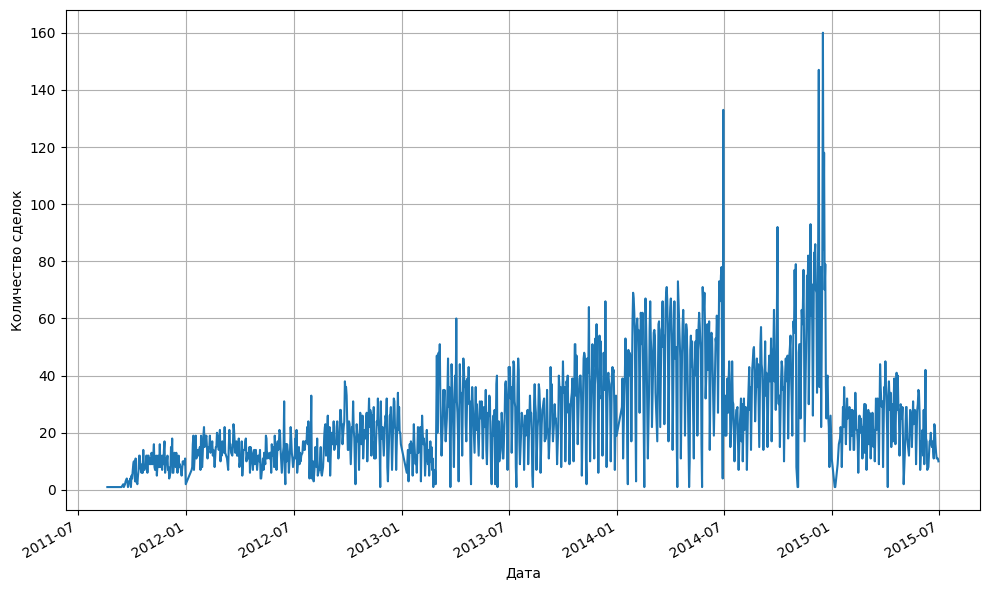

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/dataset/train.csv',
    delimiter=',')

data['timestamp'] = pd.to_datetime(data['timestamp'])
plt.figure(figsize=(10, 6))
data['timestamp'].value_counts().sort_index().plot()
plt.xlabel('Дата')
plt.ylabel('Количество сделок')
plt.grid(True)
plt.tight_layout()
plt.show()

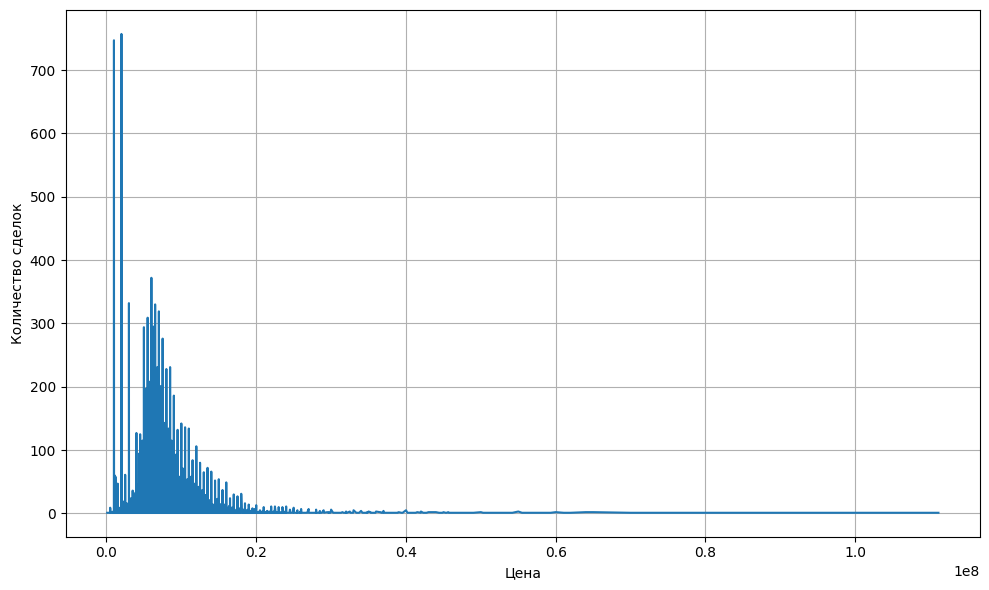

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/dataset/train.csv',
    delimiter=',')


plt.figure(figsize=(10, 6))
data['price_doc'].value_counts().sort_index().plot()
plt.xlabel('Цена')
plt.ylabel('Количество сделок')
plt.grid(True)
plt.tight_layout()
plt.show()


**Базовый отбор признаков**

In [ ]:
corr_with_price = new.corr()['price_doc'].sort_values(ascending=False) #запуск с ранее очищенным от пустых значений и шумов датасетом

<ipython-input-171-4387bfef602c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_with_price = new.corr()['price_doc'].sort_values(ascending=False) #запуск с ранее очищенным от пустых значений и шумов датасетом


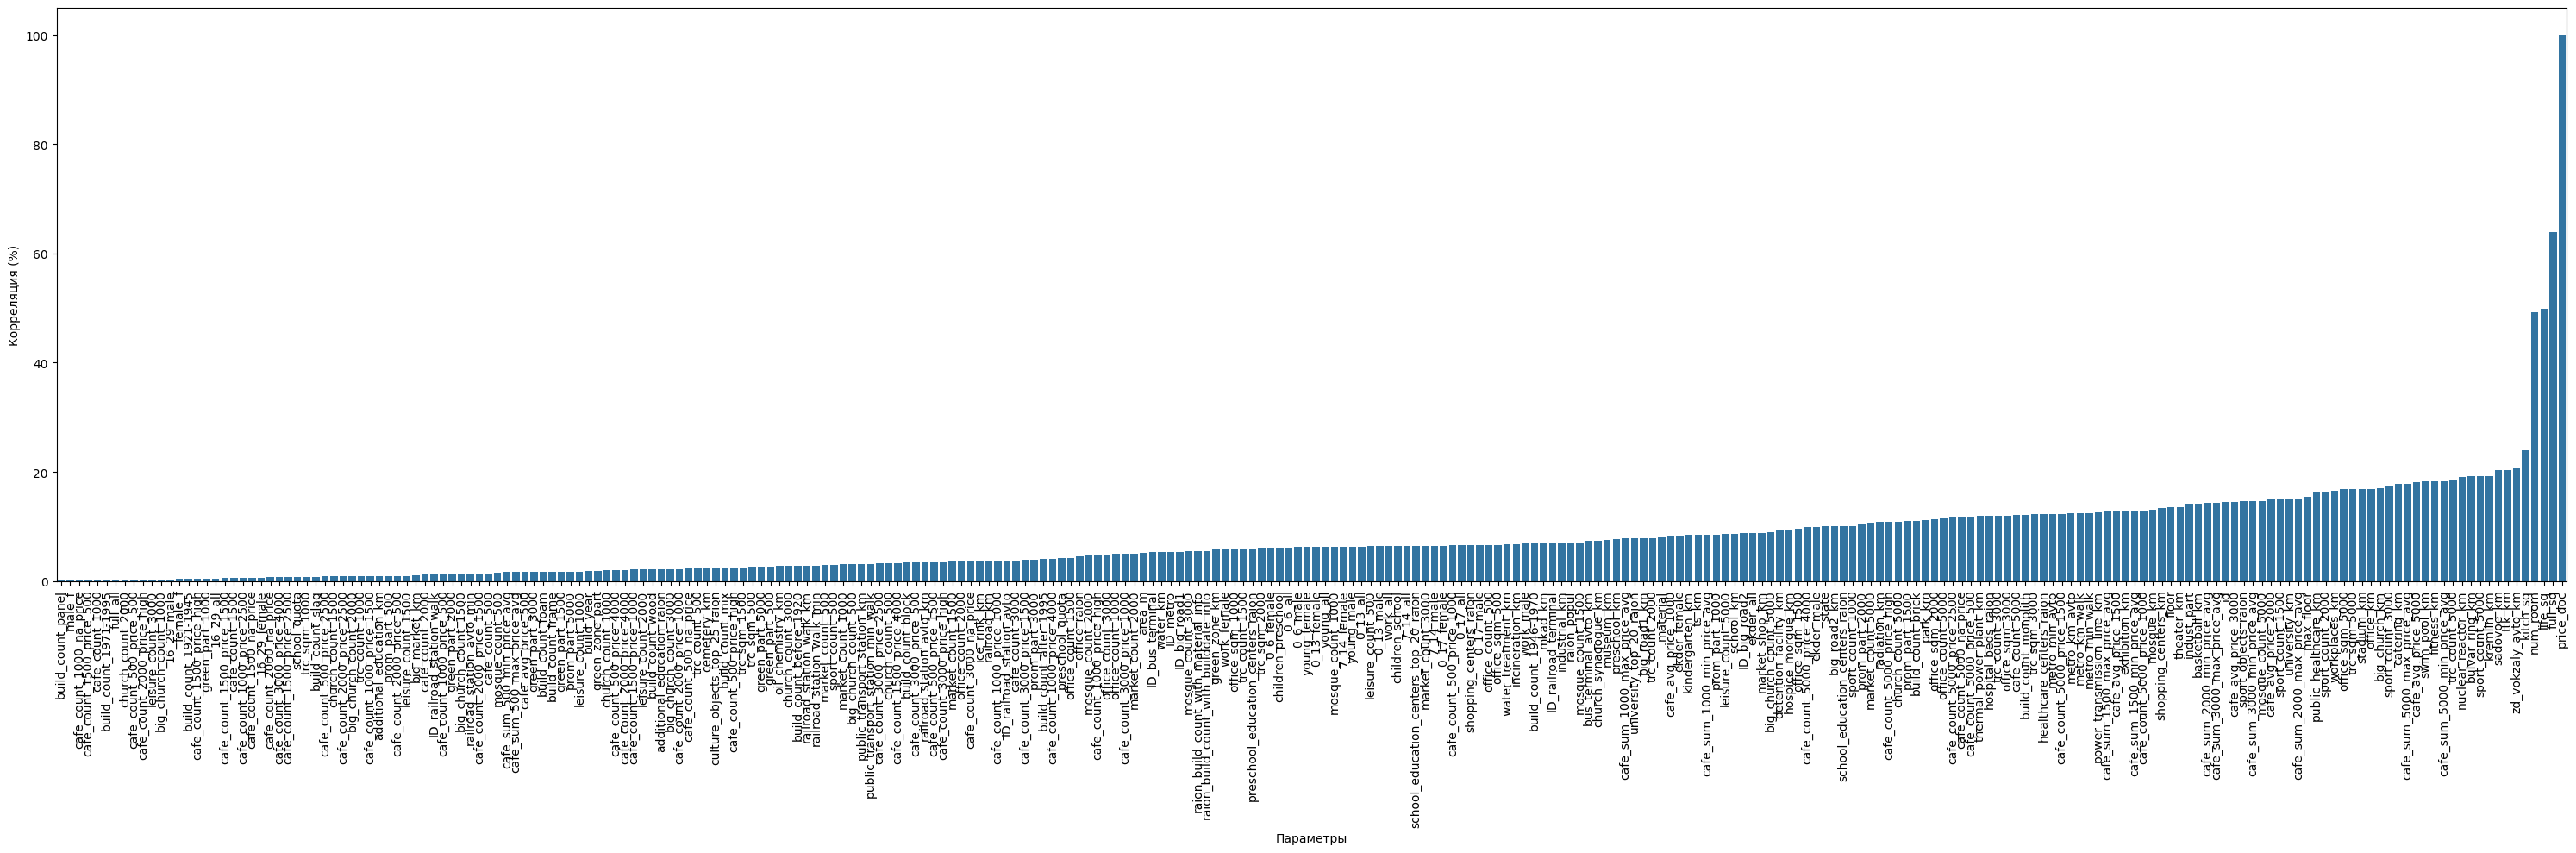

In [ ]:
corr_percent = corr_with_price.abs().sort_values() * 100

plt.figure(figsize=(30, 10))
sns.barplot(x=corr_percent.index, y=corr_percent.values)
plt.xlabel('Параметры')
plt.ylabel('Корреляция (%)')
plt.xticks(rotation=90)
plt.tight_layout()


**Статистики**

In [ ]:
import pandas as pd
import numpy as np

df = new.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')
df['year'] = df['timestamp'].dt.year

dict = {}
for i in range(2011, 2016):
  dict[i] = (np.asarray(df[df['year'] == i]['price_doc'], dtype=np.float64) / np.asarray(df[df['year'] == i]['full_sq'], dtype=np.float64)).mean()
dict


{2011: 123810.2077356866,
 2012: 131377.21511700845,
 2013: 134283.78606198716,
 2014: 146414.6583147022,
 2015: 156573.09749847985}